---
## LPC를 이용한 vocoder의 구성
### 작성자 : 전인구

In [83]:
import numpy as np
import librosa
from librosa import lpc
from numpy.random import normal
from scipy.signal import lfilter

class filter:
    def __init__(self,M=14):
        self.M=M
        self.memory=np.zeros(M)
        self.weight=np.zeros(M+1)
        self.weight[0]=1
    def set_weight(self,w):
        self.weight=w        
        
class FIR(filter):
    def __init__(self,M):
        super().__init__(M)
        
    def use(self,x):
        L_out=len(x)
        filtered=np.convolve(
                            np.concatenate([self.memory,x]),
                            self.weight
                            ,"same")
        x_out=filtered[-L_out:]
        self.memory=x[-self.M:]
        return x_out
    
    def imp_response(self,scale=1024):
        imp=np.zeros(scale)
        imp[0]=1
        filtered=np.convolve(imp,self.weight,"same")
        IMP=np.fft.fft(filtered)
        
        return np.abs(IMP[:scale//2+1])
        
class IIR(filter):
    def __init__(self,M):
        super().__init__(M)
    
    def use(self,x):
        L_out=len(x)
        filtered=np.zeros(L_out)
        mem=self.memory
        for idx in range(L_out):
            filtered[idx]=x[idx]*self.weight[0]\
                        -np.sum(mem*(self.weight[1:]))
            if self.M==1:
                mem=filtered[idx]
            else:
                mem[1:]=mem[:-1]
                mem[0]=filtered[idx]
        self.memory=mem
        return filtered
    
    def imp_response(self,scale=1024):
        imp=np.zeros(scale)
        imp[0]=1
        filtered=np.zeros(scale)
        mem=np.zeros(self.M)
        for idx in range(scale):
            filtered[idx]=imp[idx]*self.weight[0]\
                        -np.sum(mem*(self.weight[1:]))
            if self.M==1:
                mem=filtered[idx]
            else:
                mem[1:]=mem[:-1]
                mem[0]=filtered[idx]        
            
        IMP=np.fft.fft(filtered)
        
        return np.abs(IMP[:scale//2+1])
    
class vocoder:
    def __init__(self,M=14,alpha=0.95,Fs=16000,eps=1e-6):
        self.Fs=Fs
        self.Ns=int(Fs*0.01)
        self.Ncat=self.Ns*2
        self.x_pn_prev=np.zeros(Ns)
        # Pre Emphasis
        self.emp=FIR(M=1)
        self.emp.set_weight(np.array([1,-alpha]))
        
        self.eps=eps
        
        self.hamm = librosa.filters.get_window('hamming', self.Ncat)
        
        self.LPCenc=FIR(M)
        self.LPCdec=IIR(M)
        
        
        # De Emphasis
        self.dem=IIR(M=1)
        self.dem.set_weight(np.array([1,-alpha]))
        
    def Encoding(self,x):
        # Pre-emphasis
        x_p=self.emp.use(x)
        
        # add tiny Guassian
        x_pn=x_p+normal(0,self.eps,self.Ns) 
        
        # apply Hamming window
        x_pnw=np.concatenate([self.x_pn_prev,x_pn])*self.hamm
        
        # LPC encoding
        A=lpc(x_pnw,self.LPCenc.M)
        self.LPCenc.set_weight(A)
        e=self.LPCenc.use(x_pn)
        G=np.max(np.abs(e))
        e=e/G
        self.x_pn_prev=x_pn
        
        result=(x_p,x_pn,e,A,G)
        
        return result
    
    def Decoding(self,e,a,G):
        # LPC decoding
        self.LPCdec.set_weight(a)
#         e=e*G
        x_pn_hat=self.LPCdec.use(e)
        # De-emphasis
        x_hat=self.dem.use(x_pn_hat)*G
        
        result=(x_pn_hat,x_hat)
        
        return result
    
    def Evaluate(self,x,x_hat):
        if len(x)<len(x_hat):
            x_hat=x_hat[:len(x)]
        err=x-x_hat
        
        SNR=10*np.log10(np.sum(x**2))-10*np.log10(np.sum(err**2))
        print(SNR)
        return err

-1.5792675415266828


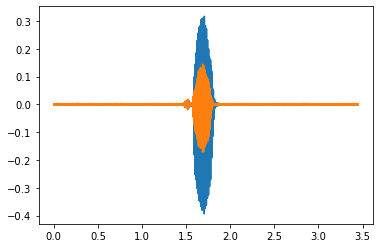

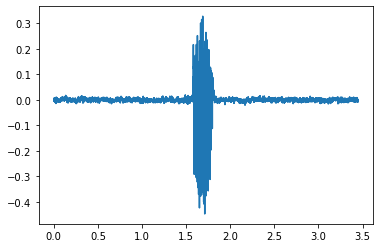

In [86]:
Fs=16000

L_random=int(Fs)
Ns=int(Fs*0.01)

filename="./kdigits1-3.wav"
# filename="./kdigits_custom/InkooJeon/0/kdigits0-0.wav"

x,fs=librosa.load(filename)
# x=x[int(Fs):int(Fs*2.5)]

vc=vocoder(alpha=0.98,eps=1e-3)

H_test=FIR(M=14)


X_hat=[]
E=[]
X_p=[]
X_pn=[]
X_pn_hat=[]

max_iter=int((len(x)+Ns-1)//Ns)
for idx in range(max_iter):
    if idx >=len(x)//Ns:
        x_tmp=x[(idx)*Ns:]
        x_i=np.concatenate([x_tmp,np.zeros(Ns-len(x_tmp))])
    else:
        x_i=x[(idx)*Ns:(idx+1)*Ns]
    
    x_p,x_pn,e,a,G=vc.Encoding(x_i)
#     print(len(a))
    x_pn_hat,x_hat=vc.Decoding(e,a,G)

    E.append(e)
    X_hat.append(x_hat)
    X_p.append(x_p)
    X_pn.append(x_pn)
    X_pn_hat.append(x_pn_hat)
        
    
#     print(f"[{idx}th] done!")
    
    
X_hat=np.concatenate(X_hat)
E=np.concatenate(E)
X_p=np.concatenate(X_p)
X_pn=np.concatenate(X_pn)
X_pn_hat=np.concatenate(X_pn_hat)


import matplotlib.pyplot as plt

time=np.arange(len(X_hat))/Fs

plt.figure()

plt.plot(time[-len(x):],x)
plt.plot(time,X_pn)
# plt.plot(time,E)
# plt.plot(time,X_p)

err=vc.Evaluate(x,X_hat)

plt.figure()
plt.plot(time,X_hat)
# plt.plot(time,E)
# plt.plot(time,X_pn_hat)
# plt.plot(time,err)



#### eps=1e-3일때는 복구가 되는거 처럼 보이는데, 1e-6에서는 복구가 안되는 문제가 있다.
#### 아마도 진폭이 너무 작아서 발산하는 문제가 있는 것으로 생각된다.

[ 1.         -0.02811467  0.06925387  0.11172011  0.06768272  0.09122089
 -0.09532639  0.08732594  0.0302419   0.12523437  0.10004005  0.00970905
  0.04480798 -0.05366752  0.07571108]
[ 1.         -0.02811467  0.06925387  0.11172011  0.06768272  0.09122089
 -0.09532639  0.08732594  0.0302419   0.12523437  0.10004005  0.00970905
  0.04480798 -0.05366752  0.07571108]


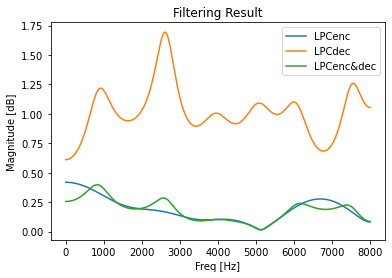

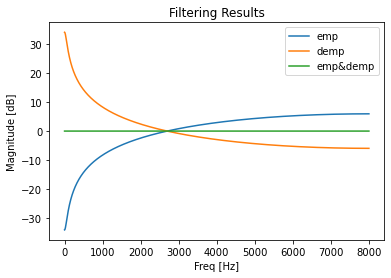

In [87]:
L_time=4096

Freq=np.arange(L_time//2+1)*Fs/L_time
H_enc=vc.LPCenc.imp_response(L_time)
H_dec=vc.LPCdec.imp_response(L_time)

plt.plot(Freq,H_enc)
plt.plot(Freq,H_dec)
plt.plot(Freq,H_enc*H_dec)
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("Filtering Result")
plt.legend(["LPCenc","LPCdec","LPCenc&dec"])
print(vc.LPCenc.weight)
print(vc.LPCdec.weight)

H_emp=vc.emp.imp_response(L_time)
H_dem=vc.dem.imp_response(L_time)
plt.figure()
plt.plot(Freq,np.log10(H_emp)*20)
plt.plot(Freq,np.log10(H_dem)*20)
plt.plot(Freq,np.log10(H_emp*H_dem)*20)
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("Filtering Results")
plt.legend(["emp","demp","emp&demp"])

#### LPCenc&dec가 0dB로 flat하게 나와야할 거 같은데, 그게 안돼서 복구가 잘 안되는 것 같다.

Text(0, 0.5, 'Difference')

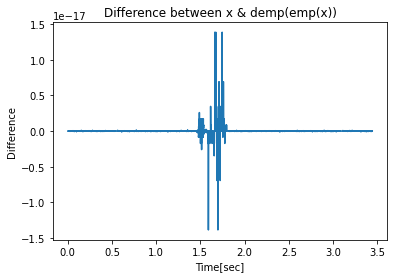

In [53]:
alpha=0.95
emp=FIR(M=1)
emp.set_weight(np.array([1,-alpha]))

dem=IIR(M=1)
dem.set_weight(np.array([1,-alpha]))

X_emp=[]
X_dem=[]

max_iter=int((len(x)+Ns-1)//Ns)
for idx in range(max_iter):
    if idx >=len(x)//Ns:
        x_tmp=x[(idx)*Ns:]
        x_i=np.concatenate([x_tmp,np.zeros(Ns-len(x_tmp))])
    else:
        x_i=x[(idx)*Ns:(idx+1)*Ns]
    
    x_emp=emp.use(x_i)
    X_emp.append(x_emp)
    
    x_dem=dem.use(x_emp)
    X_dem.append(x_dem)
    

X_emp=np.concatenate(X_emp)
X_dem=np.concatenate(X_dem)
plt.plot(time[:len(x)],x[:len(x)]-X_dem[:len(x)])
plt.title("Difference between x & demp(emp(x))")
plt.xlabel("Time[sec]")
plt.ylabel("Difference")